# 评估模型

本代码实现两个模型。第一个是一个简单的回归模型，我们展示如何调用损失函数，（训练中的MSE，最小均方误差），并且最后输出它来显示测试和训练集。

第二个模型也是个简答的模型（果然是cookbook，真正使用的时候，需要搜集现成的类keras代码，在tensorflow2.0之后已经将keras集成到tensorflow中。厉害了！！！）。我们展示如何打印分类正确率，用于比较测试和训练集。

### 回归模型

对于回归模型，我们创建100个随机采样（正态分布，均值为1，标准差为0.1）。目标是大小为100的数组，其数组元素均为10.0。

我们使用一个线性模型$y = A \cdot x$（没有y轴的偏移）。A理论值是10.0。

下一个单元是老规矩了。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()

/home/zhangxin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


开始计算图:

In [2]:
sess = tf.Session()

声明批量尺寸：

In [3]:
batch_size = 25

### 生成数据，用于回归

这里我们生成数据，用于回归。同时也指定必要的占位符。

然后将数据按照80-20的比例划分。

In [4]:
# 创建数据
x_vals = np.random.normal(1, 0.1, 100)
y_vals = np.repeat(10., 100)
x_data = tf.placeholder(shape=[None, 1], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# 将数据按照train/test=80%/20%
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

### 模型变量和运算

我们创建模型变量`A`和乘法运算。

In [5]:
# 创建变量（只有一个变量 = A）
A = tf.Variable(tf.random_normal(shape=[1,1]))

# 添加运算到计算图中
my_output = tf.matmul(x_data, A)

### 损失、优化函数和变量初始化

我们使用L2损失，以及学习速率为0.02的标准梯度下降优化算法

In [6]:
# 添加L2损失运算到计算图中
loss = tf.reduce_mean(tf.square(my_output - y_target))

# 创建优化器
my_opt = tf.train.GradientDescentOptimizer(0.02)
train_step = my_opt.minimize(loss)

# 初始化变量
init = tf.global_variables_initializer()
sess.run(init)

### 运行回归算法

我们实现100轮训练，每次选择一个随机批次的数据。

In [7]:
#　循环迭代学习
for i in range(100):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = np.transpose([x_vals_train[rand_index]])
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    if (i+1)%25==0:
        print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)))
        print('Loss = ' + str(sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})))

Step #25 A = [[5.859048]]
Loss = 16.812662
Step #50 A = [[8.5052595]]
Loss = 2.7753136
Step #75 A = [[9.473402]]
Loss = 0.93078536
Step #100 A = [[9.824101]]
Loss = 1.763243


### 评估回归模型

对于回归模型的评估，我们在训练和测试集上运行损失函数。

In [8]:
# 在测试集上评估准确率（损失值）
# 结果是 MSE on test:0.72
#       MSE on train:1.27
# 从结果看，是典型的欠拟合
mse_test = sess.run(loss, feed_dict={x_data: np.transpose([x_vals_test]), y_target: np.transpose([y_vals_test])})
mse_train = sess.run(loss, feed_dict={x_data: np.transpose([x_vals_train]), y_target: np.transpose([y_vals_train])})
print('MSE on test:' + str(np.round(mse_test, 2)))
print('MSE on train:' + str(np.round(mse_train, 2)))

MSE on test:0.72
MSE on train:1.27


# 分类例子

对于分类的例子，我们生成如下数据：

输入数据中的50个数据来自于均值为-1、标准差为-1的正态分布，另外的50个数据来自于均值为1、标准差为-1的正态分布。

上述的前面50个数据的标签为0， 后50个数据的标签为1。

我们训练两个分类模型：


- 如果 $sigmoid(x+A)<0.5$，那么可以判为类0
- 如果 $sigmoid(x+A)>=0.5$，那么可以判为类1

理论上A的值应该为

$$ - \frac{mean1 + mean2}{2} = 0$$

这里需要复位计算图，因为前面已经在计算图中构建了回归模型的计算图。

In [9]:
ops.reset_default_graph()

In [10]:
sess = tf.Session()

In [11]:
batch_size = 25

### 生成分类数据和标签

我们如前所属生成待分类的数据。然后我们创建占位符。

然后按照80-20的比例分割数据集。

In [12]:
# 创建数据
x_vals = np.concatenate((np.random.normal(-1, 1, 50), np.random.normal(2, 1, 50)))
y_vals = np.concatenate((np.repeat(0., 50), np.repeat(1., 50)))
x_data = tf.placeholder(shape=[1, None], dtype=tf.float32)
y_target = tf.placeholder(shape=[1, None], dtype=tf.float32)

# 按照80-20的比例分割数据集
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

### 模型变量和运算

我们创建模型变量`A`，以及模型的运算。该运算就是在输入数据上加`A`。注意我们没有在运算中使用`sigmoid`，因为我们在损失函数中会使用（这是因为指数运算和对数运算一起，比较利于数值运算）。那么在预测或者说推理的时候，我们需要加上sigmoid函数。当然也不能少了round函数（或者类似round函数功能的函数）。

In [13]:
# 创建变量（一个模型参数 = A）
A = tf.Variable(tf.random_normal(mean=10, shape=[1]))

# 添加运算到计算图中
# 计算sigmoid(x + A)
# 注意sigmoid()部分在损失函数中
my_output = tf.add(x_data, A)

### 损失、优化函数和变量初始化

损失函数是sigmoid-cross-entropy。最后使用`tf.reduce_mean()`来计算批量输入数据的损失值。

优化函数使用标准的梯度下降优化算法，学习速率为0.05

In [14]:
# 添加分类损失（交叉熵）
xentropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=my_output, labels=y_target))

# 创建优化器
my_opt = tf.train.GradientDescentOptimizer(0.05)
train_step = my_opt.minimize(xentropy)

# 初始化变量
init = tf.global_variables_initializer()
sess.run(init)

### 运行分类

迭代训练1800轮，并且每200轮打印`A`的值以及对应的损失值。

In [15]:
# 训练循环
for i in range(1800):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = [x_vals_train[rand_index]]
    rand_y = [y_vals_train[rand_index]]
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    if (i+1)%200==0:
        print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)))
        print('Loss = ' + str(sess.run(xentropy, feed_dict={x_data: rand_x, y_target: rand_y})))

Step #200 A = [4.995553]
Loss = 1.3597587
Step #400 A = [1.1890674]
Loss = 0.37012976
Step #600 A = [-0.04709373]
Loss = 0.2146331
Step #800 A = [-0.3991668]
Loss = 0.2874766
Step #1000 A = [-0.43760166]
Loss = 0.19997752
Step #1200 A = [-0.45347223]
Loss = 0.28302592
Step #1400 A = [-0.4420905]
Loss = 0.26215515
Step #1600 A = [-0.4457065]
Loss = 0.23396501
Step #1800 A = [-0.47649917]
Loss = 0.22531891


### 评估分类结果

Accuracy on train set: 0.925
Accuracy on test set: 0.85


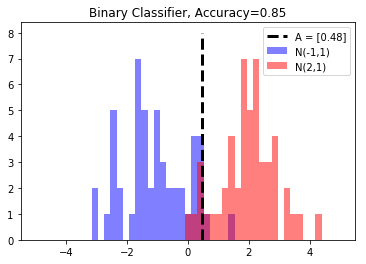

In [17]:
# 在测试集上评估模型
y_prediction = tf.squeeze(tf.round(tf.nn.sigmoid(tf.add(x_data, A))))
correct_prediction = tf.equal(y_prediction, y_target)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
acc_value_test = sess.run(accuracy, feed_dict={x_data: [x_vals_test], y_target: [y_vals_test]})
acc_value_train = sess.run(accuracy, feed_dict={x_data: [x_vals_train], y_target: [y_vals_train]})
print('Accuracy on train set: ' + str(acc_value_train))
print('Accuracy on test set: ' + str(acc_value_test))

# 画出分类结果
A_result = -sess.run(A)
bins = np.linspace(-5, 5, 50)
plt.hist(x_vals[0:50], bins, alpha=0.5, label='N(-1,1)', color='blue')
plt.hist(x_vals[50:100], bins[0:50], alpha=0.5, label='N(2,1)', color='red')
plt.plot((A_result, A_result), (0, 8), 'k--', linewidth=3, label='A = '+ str(np.round(A_result, 2)))
plt.legend(loc='upper right')
plt.title('Binary Classifier, Accuracy=' + str(np.round(acc_value_test, 2)))
plt.show()